# **Nonlinear Optimization 2024.2**

### **Optimum power for a set of $m$ lamps iluminating a set of $n$ flat patches to best approach a target illumination**

Consider $m$ lamps illuminating $n$ (small flat) patches. The illumination intensity $I_k$ at the $k$-th patch depends linearly on the lamp power $p_j$ as:

\begin{equation*}
    I_k = \displaystyle \sum_{j=1}^{m}a_{k,j}p_j, \quad \text{with} \quad a_{k,j} = r_{k,j}^{-2}\max\{cos(\theta_{k.,j}),0\},
\end{equation*}

where $r_{k,j}$ is the length of the vector $r_{k,j}$ connecting the center of the $k$-th patch to the position of the $m$-th lamp and $\theta_{k,j}$ is the angle between the patch normal vector $\mathbf{n}_k$ and $\mathbf{r}_{k,j}$. See the Convex Optimization book slides for more details.

The proposed problem is to achieve a desired illumination $I_{des}$ with bounded lamp powers ($p_{max}$), i.e.,

\begin{align*}
    & \min \underset{k=1,2,\dots,n}{\max}\vert \log{(I_k)} - \log{(I_{des})} \vert \\
    \text{s. t.}\quad & 0 \leq p_j \leq p_{max}, j = 1, 2, \dots, m.
\end{align*}

#### **Suboptimally solve the problem using, e.g., Python or Octave, according to the following approaches:**

1. Using uniform power, i.e., $p_j = p, 0 \leq p \leq p_{max}$.
2. Using least-squares, i.e., $\min . \displaystyle \sum_{k=1}^{n} (I_k - I_{des})^2$, and rounding $p_j$ as $p_j = \max\{0, \min\{p_j, p_{max}\}\}$.
3. Using weighted least-squares, i.e., $\min . \displaystyle \sum_{k=1}^{n}(I_k - I_{des})^2 + w_j\sum_{j=1}^n (p_j - p_{max})^2$ and iteratively adjusting the weights $w_j$ until $0 \leq p \leq p_{max}, \forall j$.
4. Using linear programming, i.e., 

\begin{align*}
    & \min . \underset{k=1, 2, \dots, n}{\max} \vert I_{k} - I_{des} \vert \\
    \text{s. t.} \quad & 0 \leq p_j \leq p_{max}, \quad j = 1, 2, \dots, m.
\end{align*}

#### **Solve the problem optimally using convex optimization**

For this goal, consider the equivalent convex problem

\begin{align*}
    & \min . \underset{k = 1, 2, \dots, n}{\max} h\left(\cfrac{I_k}{I_{des}}\right) \\
    \text{s. t.} \quad & 0 \leq p_j \leq p_{max}, \quad j = 1, 2, \dots, m, 
\end{align*}

where $h(u) = \max\left\{u, \cfrac{1}{u}\right\}$

In [108]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

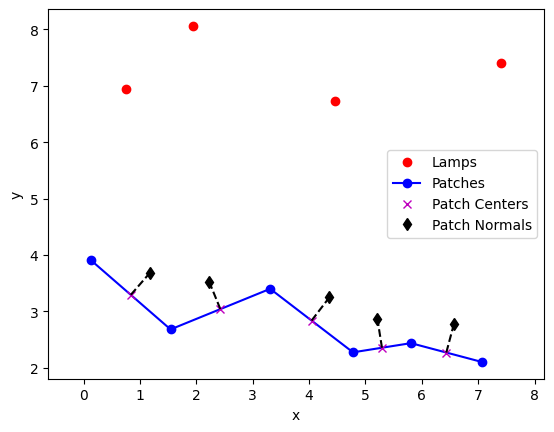

In [109]:
showFig = True
numLamps = 4            # number of lamps
numPatches = 5          # number of patches
maxPwr = 1              # maximum power
desiredillum = 0.01     # desired illumination

# Define lamp and patch positions
lampPos = np.array([
    [0.7609, 6.9497],
    [1.9382, 8.0610],
    [4.4674, 6.7316],
    [7.4095, 7.3987]
])

patchPos = np.array([
    [0.1329, 3.9041],
    [1.5435, 2.6782],
    [3.3102, 3.3981],
    [4.7796, 2.2716],
    [5.8071, 2.4345],
    [7.0621, 2.1015]
])

lampPos = lampPos[:, 0] + 1j * lampPos[:, 1]
patchPos = patchPos[:, 0] + 1j * patchPos[:, 1]
patchCenter = (patchPos[:-1] + patchPos[1:]) / 2
patchNorm = patchPos[1:] - patchPos[:-1]
minPatchLength = np.min(np.abs(patchNorm)) / 2

for p in range(len(patchNorm)):
    n = np.linalg.svd(np.array([[np.real(patchNorm[p]), np.imag(patchNorm[p])]]).T)[0][:, 1]
    patchNorm[p] = minPatchLength * (n[0] + 1j * n[1])

fig = plt.figure()

if showFig:
    plt.plot(np.real(lampPos), np.imag(lampPos), 'ro', markerfacecolor='auto', label='Lamps')
    plt.plot(np.real(patchPos), np.imag(patchPos), 'bo-', markerfacecolor='auto', label='Patches')
    plt.plot(np.real(patchCenter), np.imag(patchCenter), 'mx', markerfacecolor='auto', label='Patch Centers')
    plt.plot(np.real(patchNorm + patchCenter), np.imag(patchNorm + patchCenter), 'kd', markerfacecolor='auto', label='Patch Normals')
    
    for i in range(len(patchCenter)):
        plt.plot([np.real(patchCenter[i]), np.real(patchNorm[i] + patchCenter[i])],
                 [np.imag(patchCenter[i]), np.imag(patchNorm[i] + patchCenter[i])], 'k--')
    
    plt.axis('equal')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

radDist = np.zeros((len(patchCenter), len(lampPos)))
angShift = np.zeros((len(patchCenter), len(lampPos)))

for i in range(len(patchCenter)):
    for j in range(len(lampPos)):
        radDist[i, j] = np.abs(patchCenter[i] - lampPos[j])
        angShift[i, j] = np.angle(lampPos[j] - patchCenter[i]) - np.angle(patchNorm[i])

illumCoeff = radDist ** (-2) * np.maximum(np.cos(angShift), 0)

plt.savefig('report/figures/lamps-patches-position.pdf', format='pdf', bbox_inches='tight')

plt.show()


## **Suboptimal Approaches**

### **1. Uniform power**


$p_j = p, 0 \leq p \leq p_{max}$

For this approach, a value of power $p$ is assumed to be the same for all the lamps. By varying the value of $p$, it is possible to see how the illuminations of each patch behave.

In [110]:
def worstCase(illumination, desiredillum):
    log_I_des = np.log(desiredillum)
    log_I     = np.log(illumination)
    diff      = log_I - log_I_des
    abs_diff  = np.abs(diff)

    worst     = np.max(abs_diff)

    return worst

In [ ]:
P = np.arange(0, 0.15, 0.15/100)            # varying the value of p
currillum = np.zeros((len(P), numPatches))  # current illumination vector
worst_result = np.zeros((len(P),1))

# calculating the illumination for each value of p
for i in range(0, len(P)):
    currillum[i,:] = np.sum(illumCoeff*P[i], axis=1)
    worst_result[i] = worstCase(currillum[i,:],desiredillum)

C:\Users\room2\AppData\Local\Temp\ipykernel_25132\974805615.py:3: RuntimeWarning: divide by zero encountered in log
  log_I     = np.log(illumination)


In [ ]:
min_worst_idx = np.argmin(worst_result)

p_uniform = P[min_worst_idx]
p_uniform = np.full(4, p_uniform)

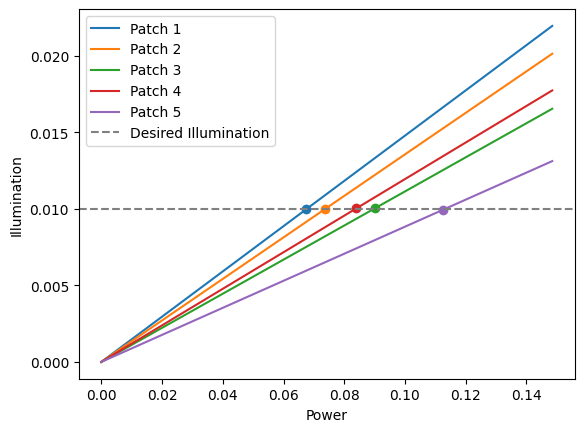

In [ ]:
# plotting the patches illumination as p increases
for i in range(5):
    plt.plot(P, currillum[:,i], label=f'Patch {i+1}')
    
    idx = np.where(np.isclose(currillum[:, i], desiredillum, atol=6e-5))[0]

    plt.scatter(P[idx], currillum[idx, i], marker='o')

# plotting desired illumination line
plt.axhline(y=desiredillum, color='gray', linestyle='--', linewidth=1.5, label='Desired Illumination')

plt.xlabel('Power')
plt.ylabel('Illumination')
plt.legend()

plt.savefig('report/figures/uniform-power.pdf', format='pdf', bbox_inches='tight')

plt.show()

<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
C:\Users\room2\AppData\Local\Temp\ipykernel_25132\1435577201.py:5: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$|\log(I) - \log(I_{des})|$')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


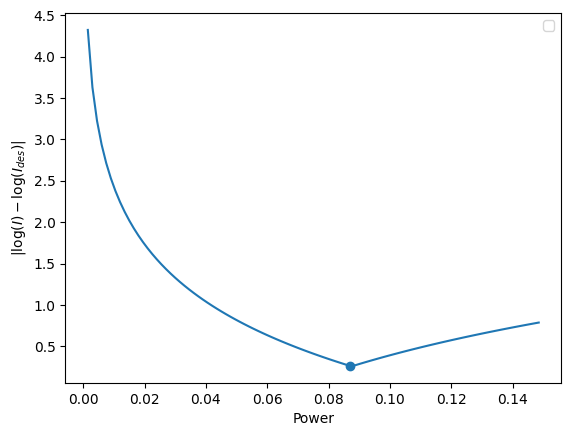

In [114]:
plt.plot(P, worst_result)
plt.scatter(P[min_worst_idx], worst_result[min_worst_idx], marker='o')

plt.xlabel('Power')
plt.ylabel('$|\log(I) - \log(I_{des})|$')
plt.legend()

plt.savefig('report/figures/uniform-power-worst.pdf', format='pdf', bbox_inches='tight')

plt.show()

The figure shows how the illumination in each patch evolves as the power $p$ grows. We see that the desired illumination is met for each patch at different values of $p$. In this manner, even though it is possible to reach the desired illumination for a patch, the others either have less or more illumination that they should.

The RMSE curve shows how the RMSE varies for the power variation. The power that minimizes it used to calculate the illumination coefficients, which are shown below.

In [115]:
illumCoeff @ p_uniform

array([0.01286644, 0.01180175, 0.00969436, 0.01039611, 0.00768935])

### **2. Least Squares**

In the least-squares approach, we aim at determining the vector of powers $p$ that minimizes the squared difference between the patche's illuminations and the desired illumination.

$$
    \min . \displaystyle \sum_{k=1}^{n} (I_k - I_{des})^2
$$

In this approach, it is not possible to set the constraints for $p$, i.e., ($0 <= p <= p_{max}$). A possible way to get over this is to set negative elements of $p$ to 0 and values greater than $p_{max}$ to be equal to $p_{max}$, i.e.,:

$$
    p_j = max\{0, min\{p_j, p_{max}\}\}
$$

The matrix form of the problem is

$$
    \min (Ap - I_{des})^2,
$$

where $A$ is the matrix of illumination coefficients $a_{kj}$, that represent the illumination coefficient of lamp j to the patch k. $p$ is the vector of lamps powers. Each element of $Ap$ gives the illumination of a patch.

The least-squares problem has a closed form for determining $p$, which is

$$
    p = (A^T A)^{-1} A^T I_{des}
$$

In [116]:
illumCoeff_T = illumCoeff.T                                         # transpose of the illumination coefficients matrix
y = np.full(5, desiredillum)                                        # desired illumination vector
p_opt = np.linalg.inv(illumCoeff_T @ illumCoeff) @ illumCoeff_T @ y # closed form for calculating p

In [117]:
print(p_opt)                            # original least-squares solution
p_opt_const = np.clip(p_opt, 0, maxPwr) # setting 0 <= p_j <= p_max
print(p_opt_const)                      # constrained least-squares solution

[-0.39888698  0.94358396 -0.1430944   0.19224969]
[0.         0.94358396 0.         0.19224969]


In [118]:
print(illumCoeff @ p_opt)       # illuminations for the original solution
print(illumCoeff @ p_opt_const) # illuminations for the constrained solution

[0.01006799 0.00981983 0.00966871 0.01050695 0.00989504]
[0.03782913 0.03693258 0.02109339 0.02549537 0.01766888]


It is possible to see that the solution obtained through least-squares produces illuminations quite close the desired. However, since it does not have constraints, there are lamps with negative powers. Additionally, the solution could also have lamps using more power than it was established. 
When fixing the negative powers, the patches' ilumination become far away from the desired.

### **3. Weighted Least Squares**

In the weighted least-squares approach, we aim at minimizing a function composed of the least-squares approach function and the squared difference between the vector $p$ and $p_{max}$, weighted by coefficients $w$. 

$$
    \min . \displaystyle \sum_{k=1}^{n}(I_k - I_{des})^2 + w_j\sum_{j=1}^n (p_j - p_{max})^2
$$

The purpose of this additional term is to penalise the cost function for values of $p_j$ that deviate from $p_{max}$. The coefficient $w_j$ determines how strong this penalty is, and it can be adjusted to meet the constraints for $p$: $0 \leq p \leq p_{max}$. In this approach, the weights must be iteratively be changed to meet the constraints.

This problem also has a closed form for $p$:

$$
    p = (A^T A + W)^{-1} \cdot (A^T I_{des} + W p_{max}),
$$

where $W \in \mathbb{R}^{m \times m}$ is the diagonal matrix of weights.

In [119]:
I_des = np.full(5, desiredillum)    # desired illumination vector
p_max = np.full(4, maxPwr)          # maximum power vector

In [ ]:
w = np.zeros(4)   # matrix of weights
max_iter = 1000  # maximum number of iterations

# the weights are adjusted untill the powers meet the constraints
for _ in range(max_iter):
    alpha = 0.01   # rate
    W = np.diag(w)  # weight's matrix

    p_opt_wls = np.linalg.inv(illumCoeff_T @ illumCoeff + W) @ (illumCoeff_T @ I_des + W @ p_max)   # calculate powers
    illumination = illumCoeff @ p_opt_wls                                                           # calculate illumination
    squared_error = (desiredillum - illumination)**2                                                # illumination squared error

    E = np.sum(squared_error)

    if (np.all(p_opt_wls >= 0) and np.all(p_opt_wls <= p_max)):
        break

    w_new = w + alpha*((p_opt_wls - p_max)**2) * E
    w = w_new
    


In [121]:
p_opt_wls   # powers vector

array([0.00020944, 0.19496187, 0.01201117, 0.19526927])

In [122]:
illumCoeff @ p_opt_wls  # illuminations for the weighted least-squares solution

array([0.0107828 , 0.00922256, 0.00986564, 0.01029437, 0.00973501])

### **4. Linear Programming**



In the linear programming approach, we aim at formulate the problem such that it has a linear objective function and linear constraints. The proposed problem is to minimize the maximum of the absolute difference between the illumination of a patch and the desired illumination. 

\begin{align*}
    & \min . \underset{k=1, 2, \dots, n}{\max} \vert I_{k} - I_{des} \vert \\
    \text{s. t.} \quad & 0 \leq p_j \leq p_{max}, \quad j = 1, 2, \dots, m.
\end{align*}

We can introduce a new variable $t$, such that $t \leq |I_k - I_{des}|, \quad \forall k = 1, \dots, n $

However, the absolute value is a nonlinear function. This way, we can add linear inequalities to contour this problem.
$$
\begin{align*}
    t \geq & I_k - I_{des}, \quad \forall k\\
    t \geq & -(I_k - I_{des}) \quad \forall k
\end{align*}
$$
Then, the linear programming problem is defined as:
$$
\begin{align*}
    \min \quad & t\\
    s.t. \quad & t \geq I_k - I_{des} \\
               & t \geq -(I_k - I_{des}) \\
               & 0 \leq p_j \leq p_{max}, \quad j = 1, \dots, m
\end{align*}
$$



In [123]:
import cvxpy as cp  # cvxpy library

In [124]:
p = cp.Variable(4, nonneg=True)  # vector of powers
t = cp.Variable()   # new variable t

In [125]:
objective = cp.Minimize(t)  # the objective is to minimize t

In [126]:
# adding the constraints
constraints = [
    t >= (illumCoeff @ p ) - I_des,     # t must be greater than or equal to the difference between the                                 # patches' illumination and the desired illumination
    t >= -((illumCoeff @ p) - I_des),   # t must also be greater than the negative of the alredy described vector.
    p <= p_max                          # the powers must be less than the p_max
]

In [127]:
problem = cp.Problem(objective, constraints)    # optimization problem
problem.solve()                                 # solving the optimization problem

0.0007120545889562882

In [128]:
p_lp = p.value  # linear programming solution
print(p_lp)

[9.34800349e-08 1.60824541e-01 6.00384603e-02 1.50503641e-01]


In [129]:
illumCoeff @ p_lp   # illuminations obtained with the linear programming solution

array([0.01071205, 0.00928795, 0.01059634, 0.01071204, 0.00928795])

The Linear Programming approach produces illuminations quite close to the desired without consuming much power as the previous approach. 

## **Optimal Approach**

### **Convex Optimization**

In this approach, the problem is formulated as to minimize a convex function. 

\begin{align*}
    & \min . \underset{k = 1, 2, \dots, n}{\max} h\left(\cfrac{I_k}{I_{des}}\right) \\
    \text{s. t.} \quad & 0 \leq p_j \leq p_{max}, \quad j = 1, 2, \dots, m, 
\end{align*}

where $h(u) = \max\left\{u, \cfrac{1}{u}\right\}$

As $I_k$ approaches $I_{des}$, the fraction $\cfrac{I_k}{I_{des}}$ gets closer to 1. The function $h(I_k/I_{des})$ produces great values when $I_k < I_{des}$ and linearly crescent values when $I_k > I_{des}$. This way, $h(\cdot)$ has as its minimum the value 1, i.e., when $I_k = I_{des}$. This way, when minimizing $h(\cdot)$, we are aiming at minimizing the difference between $I_k$ and $I_{des}$. The plot below shows the behaviour of $h(\cdot)$.

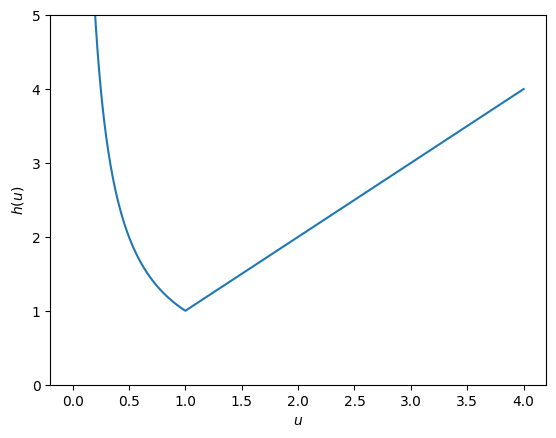

In [130]:
x = np.linspace(0.001,4,1000)
y = np.maximum(x,1/x)

plt.ylim(0, 5)

plt.plot(x, y)
plt.xlabel('$u$')
plt.ylabel('$h(u)$')

plt.savefig('report/figures/convex-function.pdf', format='pdf', bbox_inches='tight')

plt.show()

In [131]:
import cvxpy as cp  # cvxpy library

In [132]:
p = cp.Variable(4, nonneg=True) # vector of powers, nonnegative
t = cp.Variable(nonneg=True)    # additional variable t
s = cp.Variable(nonneg=True)    # additional variable s

In [133]:
objective = cp.Minimize(t)  # the objective is to minimize t

In [134]:
# problem's constrains
constraints = [
    (illumCoeff @ p) / I_des <= t,  # I_k / I_des <= t
    s * I_des <= illumCoeff @ p,    # s * I_des <= I_k
    t * s >= 1,                     # s = t / 1
    p <= p_max                      # p <= p_max
]

In [135]:
problem = cp.Problem(objective, constraints)    # optimization problem
problem.solve(qcp=True, solver=cp.SCS)          # solving optimization problem

1.0739097099420345

In [136]:
p_cvx = p.value # convex optimization solution

In [137]:
illumCoeff @ p_cvx  # illuminations given by the convex optimizatio solution

array([0.01073933, 0.00931156, 0.01062336, 0.01073936, 0.00931171])

### **Comparing Methods**

In [139]:
ill_uniform  = illumCoeff @ p_uniform
ill_ls       = illumCoeff @ p_opt
ill_ls_const = illumCoeff @ p_opt_const
ill_wls      = illumCoeff @ p_opt_wls
ill_lp       = illumCoeff @ p_lp
ill_cvx      = illumCoeff @ p_cvx

In [145]:
worst_uni      = worstCase(ill_uniform,  desiredillum)
worst_ls       = worstCase(ill_ls,       desiredillum)
worst_ls_const = worstCase(ill_ls_const, desiredillum)
worst_wls      = worstCase(ill_wls,      desiredillum)
worst_lp       = worstCase(ill_lp,       desiredillum)
worst_cvx      = worstCase(ill_cvx,      desiredillum)

In [147]:
methods = ['Uniform Power', 'Least-Squares', 'Weighted Least-Squares', 'Linear Programming', 'Convex Optimization']
worst_all = [worst_uni, worst_ls_const, worst_wls, worst_lp, worst_cvx]

In [148]:
stats = {'Method': methods, 'Worst case': worst_all}
stats = pd.DataFrame(stats)
# stats.index = methods

stats = stats.style.set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'center')]},         # align column headers
     {'selector': 'td', 'props': [('text-align', 'left')]},       # align data to the center
     {'selector': 'thead th', 'props': [('text-align', 'center')]}    # ensure headers are aligned left
    ], axis=None)

display(stats)

,Method,Worst case
0,Uniform Power,0.262749
1,Least-Squares,1.330494
2,Weighted Least-Squares,0.080933
3,Linear Programming,0.073868
4,Convex Optimization,0.071330
